# Data Science applied to CEDAE data

CEDAE is the coorporation that provides drinking water and wastewater services for the Rio de Janeiro State.
They provide plenty of data regarding the quality of the water for the press and for the population, due to laws imposed by the Ministry of Health of Brazil.

There are data for physical, chemical and biological parameters of the drinking water of all ETAs (Estações de Tratamento de Água, or _Water Treatment Stations_).
Amongst the ETAs managed by CEDAE is the Guandu, the largest ETA of the world, which provides drinking water for the municipalities of Nilópolis, Nova Iguaçu, Duque de Caxias, Belford Roxo, São João de Meriti, Itaguaí, Queimados and Rio de Janeiro.

First, we need to download the HTML page with the links to the PDFs.

In [1]:
import urllib.request

with urllib.request.urlopen('https://cedae.com.br/relatoriosguandu') as fp:
    HTML_page = fp.read().decode() # Read from page and decode to UTF-8 string

Then we define an `HTMLParser` class for scrapping hyperlinks.

In [2]:
import html.parser
import urllib.parse

class HyperlinkScraper(html.parser.HTMLParser):
    
    def __init__(self, predicate):
        super().__init__()
        self.link = None
        self.links = dict()
        self.year = None
        self.in_h2 = False
        self.pred = predicate

    def handle_starttag(self, tag, attrs):
        if tag == 'a':
            for name, value in attrs:
                if name == 'href':
                    # Heuristic: if URL has %, it must be already formatted.
                    # If not, format only the URL path
                    if '%' in value:
                        self.link = value
                    else:
                        urlparts = value.split('/')
                        filename = urllib.parse.quote(urlparts[-1])
                        self.link = '/'.join(urlparts[:-1] + [filename])
        elif tag == 'h2':
            self.in_h2 = True

    def handle_data(self, data):
        if self.in_h2:
            # When in h2, search for a year
            for word in data.split():
                if word.isdigit():
                    number = int(word)
                    # CEDAE was created in 1975
                    # 2100 seems a good upper bound here
                    if 1975 <= number <= 2100:
                        self.year = number
                        break
        if self.link and self.year and self.pred(data):
            # If inside an <a> tag, and any link was found,
            # and an year was found and the predicate is true,
            # then add the links to the set of links of that year
            if self.year not in self.links:
                self.links[self.year] = set()
            self.links[self.year].add(self.link)

    def handle_endtag(self, tag):
        if tag == 'a':
            self.link = None
        elif tag == 'h2':
            self.in_h2 = False

Let's also make sure that the output directories are created.

In [3]:
import os

def mkdirf(directory):
    try:
        os.mkdir(directory)
        print(f'{directory} created')
    except FileExistsError:
        print(f'{directory} already existed')

mkdirf('output')
mkdirf(os.path.join('output', 'guandu'))

output created
output/guandu created


# Geosmin / MIB (per ETA)

We then feed the parser with the HTML page contents and get the scrapped links. We are first interested in data relating to geosmin.

In [4]:
def geosmin_predicate(data):
    return 'GEOSMINA' in data.upper()

geosmin_scraper = HyperlinkScraper(geosmin_predicate)
geosmin_scraper.feed(HTML_page)

Finally, we download the PDFs and convert them to pandas DataFrames.

In [5]:
import urllib.parse
import tabula

geosmin_dfs = {}
for year, links in geosmin_scraper.links.items():
    assert len(links) == 1, "Assumed there is 1 report per year"
    link = next(iter(links))
    with urllib.request.urlopen(link) as fp:
        geosmin_dfs[year] = tabula.read_pdf(fp,
                                    pages='all',
                                    silent=True)

If you were to look at the PDFs in the `data` directory, you'd see that the tables have a merged cell in the header with the text "CONCENTRAÇÃO TOTAL - GEOSMINA / MIB". Tabula simply assumes this is indeed a column. The consequence is that the subcolumns are all crammed together.

In [6]:
geosmin_dfs[2021][0][:10]

,Unnamed: 0,CONCENTRAÇÃO TOTAL - GEOSMINA / MIB
0,NaN,Análises Terceirizadas - Laboratório Mérieux N...
1,DATA DE COLETA,NaN
2,NaN,Saída de Tratamento Saída de Tratamento
3,NaN,Ponto de Captação
4,NaN,VETA NETA
5,NaN,(mg/L)
6,NaN,(mg/L) (mg/L)
7,01/01/2021,"<0,010 <0,010 <0,010"
8,02/01/2021,"<0,010 <0,010 <0,010"
9,03/01/2021,"<0,010 <0,010 <0,010"


One important discontinuity in the data is that before 18/03/2020, the concentration of geosmin and MIB of both ETAs (new and old, VETA and NETA) were averaged. After these date, these concentrations were measured and exposed separetely, since they are independent.

A solution to this problem is to create four time series: before capture, VETA, NETA and the medium between VETA and NETA. For measurements later than 18/03/2020, calculating the weighted mean of the VETA and NETA values requires a missing data: the flow rate of each ETA.

Also, we remove the header of these tables.

In [7]:
from datetime import datetime

headerless_geosmin_dfs = {}
date_format = '%d/%m/%Y'

# Find the first row where the the value in the first
# column (date) is a valid date in the format above
# and remove any rows before it
for year, df_list in geosmin_dfs.items():
    headerless_geosmin_dfs[year] = []
    for df in df_list:
        assert len(df.columns) == 2, "Assumed data frames have 2 columns initially"
        new_df = df.copy()
        new_df.columns = ['date', 'params']
        for row_idx, row in new_df.iterrows():
            try:
                date = datetime.strptime(str(row.date), date_format)
            except ValueError:
                pass
            else:
                headerless_geosmin_dfs[year].append(new_df[row_idx:])
                break

headerless_geosmin_dfs[2021][2][:10]

,date,params
7,28/03/2021,"0,077 0,092 0,020"
8,29/03/2021,"0,521 0,170 0,045"
9,30/03/2021,"0,495 0,109 0,018"
10,31/03/2021,"0,732 0,261 0,049"
11,01/04/2021,"0,726 0,194 0,052"
12,02/04/2021,"1,551 0,088 0,066"
13,03/04/2021,"1,166 0,516 0,080"
14,04/04/2021,"1,905 0,493 0,088"
15,05/04/2021,"0,537 0,308 0,075"
16,06/04/2021,"0,641 0,152 0,033"


Then, we split the "params" column into "capture", "veta" and "neta" for measurements after 18/03/2020, and into "capture", "etas" before this date.

In [8]:
separated_geosmin_dfs = {}

for year, df_list in headerless_geosmin_dfs.items():
    separated_geosmin_dfs[year] = []
    for df_index, df in enumerate(df_list):
        new_df = df.copy()
        if year == 2020 and df_index == 0:
            columns = ['capture', 'etas']
        else:
            columns = ['capture', 'veta', 'neta']
        new_df[columns] = new_df['params'].str.split(n=len(columns)-1, expand=True)
        del new_df['params']
        separated_geosmin_dfs[year].append(new_df)

separated_geosmin_dfs[2020][1][:10]

,date,capture,veta,neta
7,23/10/2020,"<0,010","<0,010","<0,010"
8,24/10/2020,"<0,010","<0,010","<0,010"
9,25/10/2020,"<0,010","<0,010","<0,010"
10,26/10/2020,"<0,010","<0,010","<0,010"
11,27/10/2020,"<0,010","<0,010","<0,010"
12,28/10/2020,"<0,010","<0,010","<0,010"
13,29/10/2020,"<0,010","<0,010","<0,010"
14,30/10/2020,"<0,010","<0,010","<0,010"
15,31/10/2020,"<0,010","<0,010","<0,010"
16,01/11/2020,"<0,010","<0,010","<0,010"


Now, we convert the strings into numbers and dates.

We see that values lower than 0.010 micrograms per liter are supressed. In order to keep that information, we'll store the upper bound. This solution is better than cramming all uncertainties to zero because throughout the time series there are different upper bounds and cramming them all to zero would mean in loss of information. Additionally, for each data column, a column will be created to indicate whether the value is uncertain or not.

In [9]:
import pandas as pd

formatted_geosmin_dfs = {}
for year, df_list in separated_geosmin_dfs.items():
    formatted_geosmin_dfs[year] = []
    for df_index, df in enumerate(df_list):
        new_df = df.copy()
        if year == 2020 and df_index == 0:
            columns = ['capture', 'etas']
        else:
            columns = ['capture', 'veta', 'neta']
        new_df.date = pd.to_datetime(new_df.date, dayfirst=True)
        for column in columns:
            new_df[f'is_{column}_ub'] = df[column].str.contains('<')
            new_df[column] = pd.to_numeric(df[column]
                                      .str.replace(' ', '')    # any space is removed
                                      .str.replace('<', '')    # supress uncertainties
                                      .str.replace(',', '.'))  # use . as decimal delimiter
        formatted_geosmin_dfs[year].append(new_df)
                                      

formatted_geosmin_dfs[2021][0][:10]

,date,capture,veta,neta,is_capture_ub,is_veta_ub,is_neta_ub
7,2021-01-01,0.010,0.01,0.01,True,True,True
8,2021-01-02,0.010,0.01,0.01,True,True,True
9,2021-01-03,0.010,0.01,0.01,True,True,True
10,2021-01-04,0.010,0.01,0.01,True,True,True
11,2021-01-05,0.010,0.01,0.01,True,True,True
12,2021-01-06,0.010,0.01,0.01,True,True,True
13,2021-01-07,0.010,0.01,0.01,True,True,True
14,2021-01-08,0.010,0.01,0.01,True,True,True
15,2021-01-09,0.013,0.01,0.01,False,True,True
16,2021-01-10,0.010,0.01,0.01,True,True,True


We then concatenate the data frames with same columns.

In [10]:
geosmin_df1 = None
geosmin_df2 = []

for year, df_list in sorted(formatted_geosmin_dfs.items()):
    for df_index, df in enumerate(df_list):
        if year == 2020 and df_index == 0:
            geosmin_df1 = df
        else:
            geosmin_df2.append(df)

geosmin_df2 = pd.concat(geosmin_df2, ignore_index=True)

Now that the data is nicely formatted, we can plot them with `matplotlib`

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

First, the data before 18/03/2020.

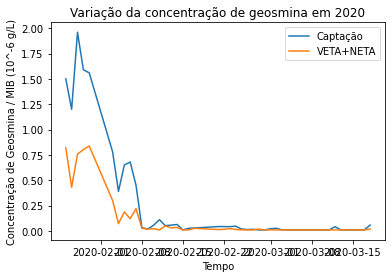

In [12]:
plt.plot(geosmin_df1.date, geosmin_df1.capture, label='Captação')
plt.plot(geosmin_df1.date, geosmin_df1.etas, label='VETA+NETA')
plt.xlabel('Tempo')
plt.ylabel('Concentração de Geosmina / MIB (10^-6 g/L)')
plt.title('Variação da concentração de geosmina em 2020')
plt.legend()
plt.show()

And then, after this date.

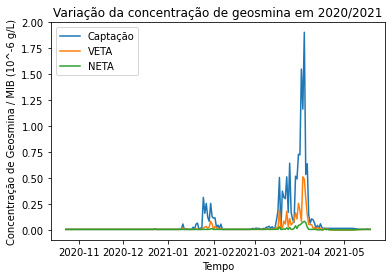

In [13]:
plt.plot(geosmin_df2.date, geosmin_df2.capture, label='Captação')
plt.plot(geosmin_df2.date, geosmin_df2.veta, label='VETA')
plt.plot(geosmin_df2.date, geosmin_df2.neta, label='NETA')
plt.xlabel('Tempo')
plt.ylabel('Concentração de Geosmina / MIB (10^-6 g/L)')
plt.title('Variação da concentração de geosmina em 2020/2021')
plt.legend()
plt.show()

We then export this data in the CSV format.

In [14]:
geosmin_df1.to_csv(os.path.join('output', 'guandu', 'geosmin_2020-01-26_2020-03-18.csv'), index=False)
geosmin_df2.to_csv(os.path.join('output', 'guandu', 'geosmin_2020-10-23_today.csv'), index=False)

# Taste and Odor (per ETA)

We are now interested in obtaining data about taste and odor (`tno`) of the water in the VETA and NETA water treatment stations. We'll be reusing the HTML data in order to extract the hyperlinks to these PDFs.

In [15]:
def tno_predicate(data):
    data = data.upper()
    return 'GOSTO E ODOR' in data and 'SAÍDA DE TRATAMENTO' in data

tno_scraper = HyperlinkScraper(tno_predicate)
tno_scraper.feed(HTML_page)

We now download the PDFs just like we did before...

In [16]:
tno_dfs = {}
for year, links in tno_scraper.links.items():
    assert len(links) == 1, "Assumed there is 1 report per year"
    link = next(iter(links))
    with urllib.request.urlopen(link) as fp:
        tno_dfs[year] = tabula.read_pdf(fp,
                                    pages='all',
                                    silent=True)

Let's take a peek at these data frames...

In [17]:
tno_dfs[2021][0][:10]

,Unnamed: 0,Análises Terceirizadas - Laboratório Oceanus - Contrato 138/2020 DSG
0,NaN,SAÍDA TRATAMENTO - NETA SAÍDA TRATAMENTO - VETA
1,DATA DE COLETA,NaN
2,NaN,GOSTO ODOR GOSTO ODOR
3,01/01/2021,2 1 2 1
4,02/01/2021,2 1 2 1
5,03/01/2021,2 1 2 2
6,04/01/2021,2 1 2 1
7,05/01/2021,2 1 1 1
8,06/01/2021,2 1 2 1
9,07/01/2021,2 1 2 1


We see that the merged cells confound the tabula parser just like with the geosmin case. Thus, we employ a similar heuristic of removing the first rows whose values in the first column aren't dates.

In [18]:
filtered_tno_dfs = {}
for year, df_list in tno_dfs.items():
    filtered_tno_dfs[year] = []
    for df_idx, df in enumerate(df_list):
        if len(df.columns) != 2:
            print('Ignored table #%d from year #%d:' % (df_idx, year))
            print(df.head())
            print()
            continue
        new_df = df.copy()
        new_df.columns = ['date', 'params']
        not_dates = []
        for row_idx, row in new_df.iterrows():
            try:
                date = datetime.strptime(str(row.date), date_format)
            except ValueError:
                not_dates.append(row_idx)
        filtered_tno_dfs[year].append(new_df.drop(not_dates))

Ignored table #1 from year #2020:
     18  Unnamed: 0 Unnamed: 1  Unnamed: 2
0  16.0  09/02/2020        NaN  09/02/2020
1   NaN  10/02/2020        NaN  10/02/2020
2  14.0         NaN        NaN         NaN
3   NaN  11/02/2020        NaN  11/02/2020
4  12.0         NaN        NaN         NaN

Ignored table #2 from year #2020:
   70  26/02/2020 Unnamed: 0 26/02/2020.1
0  65  27/02/2020        NaN   27/02/2020
1  60         NaN        NaN          NaN
2  55  28/02/2020        NaN   28/02/2020
3  50  29/02/2020        NaN   29/02/2020
4  45         NaN        NaN          NaN



In [19]:
filtered_tno_dfs[2021][0][:10]

,date,params
3,01/01/2021,2 1 2 1
4,02/01/2021,2 1 2 1
5,03/01/2021,2 1 2 2
6,04/01/2021,2 1 2 1
7,05/01/2021,2 1 1 1
8,06/01/2021,2 1 2 1
9,07/01/2021,2 1 2 1
10,08/01/2021,1 1 1 1
11,09/01/2021,1 1 1 1
12,16/01/2021,2 1 1 1


Now we split the params columns by separator.

In [20]:
columns = ['neta_taste', 'neta_odor', 'veta_taste', 'veta_odor']
split_tno_dfs = {}

for year, df_list in filtered_tno_dfs.items():
    split_tno_dfs[year] = []
    for df_index, df in enumerate(df_list):
        new_df = df.copy()
        new_df[columns] = df['params'].str.split(n=len(columns)-1, expand=True)
        del new_df['params']
        split_tno_dfs[year].append(new_df)

split_tno_dfs[2021][0][:10]

,date,neta_taste,neta_odor,veta_taste,veta_odor
3,01/01/2021,2,1,2,1
4,02/01/2021,2,1,2,1
5,03/01/2021,2,1,2,2
6,04/01/2021,2,1,2,1
7,05/01/2021,2,1,1,1
8,06/01/2021,2,1,2,1
9,07/01/2021,2,1,2,1
10,08/01/2021,1,1,1,1
11,09/01/2021,1,1,1,1
12,16/01/2021,2,1,1,1


Now we format the values in a standard form.

In [21]:
import pandas as pd

formatted_tno_dfs = {}
for year, df_list in split_tno_dfs.items():
    formatted_tno_dfs[year] = []
    for df_index, df in enumerate(df_list):
        new_df = df.copy()
        new_df.date = pd.to_datetime(df.date, dayfirst=True)
        for column in columns:
            new_df[f'is_{column}_ub'] = df[column].str.contains('<')
            new_df[column] = pd.to_numeric(df[column]
                                          .str.replace(' ', '')   # any space is removed
                                          .str.replace('<', ''))  # supress uncertainties
        formatted_tno_dfs[year].append(new_df)

formatted_tno_dfs[2021][0][:10]

,date,neta_taste,neta_odor,veta_taste,veta_odor,is_neta_taste_ub,is_neta_odor_ub,is_veta_taste_ub,is_veta_odor_ub
3,2021-01-01,2,1,2,1,False,False,False,False
4,2021-01-02,2,1,2,1,False,False,False,False
5,2021-01-03,2,1,2,2,False,False,False,False
6,2021-01-04,2,1,2,1,False,False,False,False
7,2021-01-05,2,1,1,1,False,False,False,False
8,2021-01-06,2,1,2,1,False,False,False,False
9,2021-01-07,2,1,2,1,False,False,False,False
10,2021-01-08,1,1,1,1,False,False,False,False
11,2021-01-09,1,1,1,1,False,False,False,False
12,2021-01-16,2,1,1,1,False,False,False,False


Finally, we concatenate all data frames into one. We are able to do this because the data is uniform.

In [22]:
tno_df = []

for year, df_list in sorted(formatted_tno_dfs.items()):
    tno_df += df_list

tno_df = pd.concat(tno_df, ignore_index=True)

We now plot the time series for taste and odor separately, since the grading may not be in the same scale.

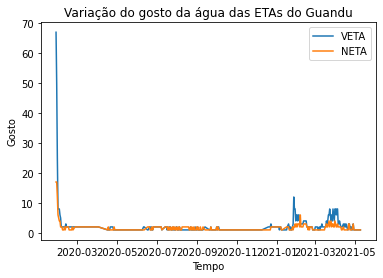

In [23]:
plt.plot(tno_df.date, tno_df.veta_taste, label='VETA')
plt.plot(tno_df.date, tno_df.neta_taste, label='NETA')
plt.xlabel('Tempo')
plt.ylabel('Gosto')
plt.title('Variação do gosto da água das ETAs do Guandu')
plt.legend()
plt.show()

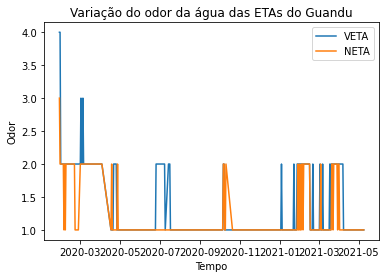

In [24]:
plt.plot(tno_df.date, tno_df.veta_odor, label='VETA')
plt.plot(tno_df.date, tno_df.neta_odor, label='NETA')
plt.xlabel('Tempo')
plt.ylabel('Odor')
plt.title('Variação do odor da água das ETAs do Guandu')
plt.legend()
plt.show()

Like before, we export this data in the CSV format.

In [25]:
tno_df.to_csv(os.path.join('output', 'guandu', 'taste_and_odor.csv'), index=False)

## Taste and Odor (in the distribution network)

CEDAE also publishes data regarding taste and odor of the water in the distribution network. The data is less frequently collected than those in the ETAs, but provides more insight about the quality of the water at specific neighbourhoods in Rio.

We now search for "REDE DE DISTRIBUIÇÃO" (distribution network) instead of "SAÍDA DE TRATAMENTO" (treatment output).

In [26]:
def tno_net_predicate(data):
    data = data.upper()
    return 'GOSTO E ODOR' in data and 'REDE DE DISTRIBUIÇÃO' in data

tno_net_scraper = HyperlinkScraper(tno_net_predicate)
tno_net_scraper.feed(HTML_page)

We download the PDFs whose titles have such text. Since the PDF from 2020 is really ill-formed, we decided to manually scrape it with Tabula and store the well-formed data in a CSV. :)

In [27]:
import pandas as pd

tno_net_dfs = {}
tno_net_files = {2020: os.path.join('input', 'guandu', 'tno_net_2020.csv')}
for year, links in tno_net_scraper.links.items():
    file = tno_net_files.get(year)
    if file is not None:
        tno_net_dfs[year] = [pd.read_csv(file)]
    else:
        assert len(links) == 1, "Assumed there is 1 report per year"
        link = next(iter(links))
        with urllib.request.urlopen(link) as fp:
            tno_net_dfs[year] = tabula.read_pdf(fp,
                                        pages='all',
                                        lattice=True,
                                        silent=True)

Let's take a peek at the data frames obtained from the PDF...

In [28]:
tno_net_dfs[2021][0][:10]

,Análises Terceirizadas - Laboratório Oceanus - Contrato 138/2020 - DSG,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6
0,DATA COLETA,CÓDIGO\rCEDAE,ENDEREÇO,BAIRRO,MUNICÍPIO,PONTO DE\rCOLETA,GOSTO,ODOR
1,04/01/2021,Am. 45/21,Avenida Candido Portinari,Barra da Tijuca,Rio de Janeiro,Rede de\rDistribuição,1,1
2,04/01/2021,Am. 48/21,Avenida das Américas,Recreio dos\rBandeirantes,Rio de Janeiro,Rede de\rDistribuição,1,1
3,04/01/2021,Am. 151/21,Rua Licinio Cardoso,São Francisco\rXavier,Rio de Janeiro,Rede de\rDistribuição,2,1
4,04/01/2021,Am. 165/21,Rua Dona Isabel,Bonsucesso,Rio de Janeiro,Rede de\rDistribuição,1,1
5,05/01/2021,Am. 596/21,Rua Conde de Porto Alegre,Centro,Duque de\rCaxias,Rede de\rDistribuição,2,1
6,05/01/2021,Am. 614/21,Rua José E M Gouvea,Olavo Bilac,Duque de\rCaxias,Rede de\rDistribuição,2,1
7,06/01/2021,Am. 814/21,Praia do Zumbi,Zumbi,Rio de Janeiro,Rede de\rDistribuição,1,1
8,06/01/2021,Am. 823/21,Avenida Paranapuã,Ilha do Governador,Rio de Janeiro,Rede de\rDistribuição,2,1
9,06/01/2021,Am. 828/20,Avenida Doutor Agenor Almeida\rLoyola,Bancários,Rio de Janeiro,Rede de\rDistribuição,2,1


And the data frame obtained from the CSV...

In [29]:
tno_net_dfs[2020][0][:10]

,date,code,address,neighbourhood,municipality,collection point,taste,odor
0,13/02/2020,Túnel\nCanal,Avenida Edson Passos,Alto da Boa Vista,Rio de Janeiro,Macro\nDistribuição,2,2
1,13/02/2020,RJ 09-A5,Avenida das Américas,Barra da Tijuca,Rio de Janeiro,Rede de\nDistribuição,2,2
2,13/02/2020,RJ 12-A7,Rua Arquias Cordeiro,Méier,Rio de Janeiro,Rede de\nDistribuição,2,2
3,13/02/2020,RJ 15-A9,Avenida Maracanã,Maracanã,Rio de Janeiro,Rede de\nDistribuição,2,2
4,13/02/2020,RJ 03-A25,Avenida Delfim Moreira,Leblon,Rio de Janeiro,Rede de\nDistribuição,2,2
5,14/02/2020,RJ 10-A16,Rua Bucareste,Vigário Geral,Rio de Janeiro,Rede de\nDistribuição,2,2
6,14/02/2020,Túnel\nCanal,Avenida Edson Passos,Alto da Boa Vista,Rio de Janeiro,Macro\nDistribuição,2,1
7,14/02/2020,RJ 17-A1,Rua Estácio de Sá,Estácio,Rio de Janeiro,Rede de\nDistribuição,2,2
8,14/02/2020,RJ 17-A4,Rua Amoroso Lima,Cidade Nova,Rio de Janeiro,Rede de\nDistribuição,2,2
9,14/02/2020,RJ 17-A5,Rua do Santana,Centro,Rio de Janeiro,Rede de\nDistribuição,2,2


We first name the columns.

In [30]:
for year, df_list in tno_net_dfs.items():
    for df in df_list:
        assert len(df.columns) == 8, "Assumed data frames have 8 columns"
        df.columns = ['date', 'code', 'address', 'neighbourhood',
                      'municipality', 'collection-point', 'taste', 'odor']

We notice that some cells contain the carriage return character `\r` and the new line character `\n`. We decide to substitute this character with a space.

In [31]:
for year, df_list in tno_net_dfs.items():
    for df in df_list:
        df.replace(['\\r', '\\n'], ' ', inplace=True, regex=True)

Now, we remove the rows whose date is not a date. This accounts for random rows with titles and not data.

In [32]:
filtered_tno_net_dfs = {}
for year, df_list in tno_net_dfs.items():
    filtered_tno_net_dfs[year] = []
    for df in df_list:
        not_dates = []
        for row_idx, row in df.iterrows():
            try:
                date = datetime.strptime(str(row.date), date_format)
            except ValueError:
                not_dates.append(row_idx)
        filtered_tno_net_dfs[year].append(df.drop(not_dates))

We now convert the columns to their well-behaved types.

In [33]:
converted_tno_net_dfs = {}
for year, df_list in filtered_tno_net_dfs.items():
    converted_tno_net_dfs[year] = []
    for df in df_list:
        new_df = df.copy()
        new_df.date = pd.to_datetime(new_df.date, dayfirst=True)
        for column in ['taste', 'odor']:
            new_df[column] = pd.to_numeric(new_df[column]
                                          .replace(' ', ''))
        converted_tno_net_dfs[year].append(new_df)

We then concatenate the data, which should be now uniform.

In [34]:
tno_net_df_list = []

for year, df_list in sorted(converted_tno_net_dfs.items()):
    tno_net_df_list += df_list

tno_net_df = pd.concat(tno_net_df_list, ignore_index=True)

We can plot now the data, not considering the location of the collection point, comparing with the ETA.

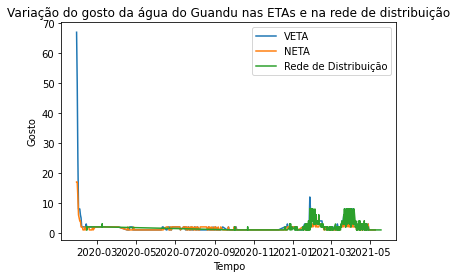

In [35]:
plt.plot(tno_df.date, tno_df.veta_taste, label='VETA')
plt.plot(tno_df.date, tno_df.neta_taste, label='NETA')
plt.plot(tno_net_df.date, tno_net_df.taste, label='Rede de Distribuição')
plt.xlabel('Tempo')
plt.ylabel('Gosto')
plt.title('Variação do gosto da água do Guandu nas ETAs e na rede de distribuição')
plt.legend()
plt.show()

And the same for odor.

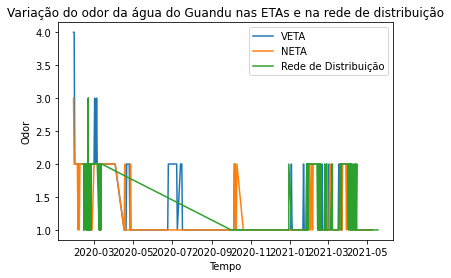

In [36]:
plt.plot(tno_df.date, tno_df.veta_odor, label='VETA')
plt.plot(tno_df.date, tno_df.neta_odor, label='NETA')
plt.plot(tno_net_df.date, tno_net_df.odor, label='Rede de Distribuição')
plt.xlabel('Tempo')
plt.ylabel('Odor')
plt.title('Variação do odor da água do Guandu nas ETAs e na rede de distribuição')
plt.legend()
plt.show()

Like before, we export this data in the CSV format.

In [37]:
tno_net_df.to_csv(os.path.join('output', 'guandu', 'taste_and_odor_net.csv'), index=False)